In [40]:
import pandas as pd
from numpy import arange
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
# Read from CSV

df1 = pd.read_csv('Outputs/packets-tcp-rfc761-plaintext-dinamico-2021.09.27-processed')
df2 = pd.read_csv('Outputs/packets-tcp-rfc761-encrypted-dinamico-2021.10.03-processed')

## Filtragem

In [42]:
# Filtering by port

is_port = df1['dstport']==8088
#print(is_port.head())
df1 = df1[is_port]
is_port = df2['dstport']==8088
df2 = df2[is_port]

In [43]:
# Filtering by the number of packets of chosen size

is_bytes = df1['payload_size']>2
df1 = df1[is_bytes]
is_bytes = df2['payload_size']>2
df2 = df2[is_bytes]

In [44]:
# Sort dataframe by an index (column) and show

df1 = df1.sort_values('shannon', ignore_index=True)
df2 = df2.sort_values('shannon', ignore_index=True)
print(df2.iloc[:,6:11])

     payload_size   shannon      bien     tbien
0            1024  0.339874  0.579085  0.886387
1            1024  0.340267  0.581560  0.885836
2            1024  0.343232  0.584646  0.890105
3             217  0.428849  0.584990  0.885353
4            1024  0.340800  0.587135  0.886223
..            ...       ...       ...       ...
152          1024  0.341082  0.662775  0.900763
153          1024  0.339837  0.663546  0.900260
154          1024  0.341552  0.666478  0.901057
155          1024  0.340703  0.668714  0.899363
156          1024  0.341407  0.670132  0.903162

[157 rows x 4 columns]


In [45]:
df = df1.iloc[:,7:10]
df = df.rename(columns={"shannon":"plaintext_shannon","bien":"plaintext_bien","tbien":"plaintext_tbien"})


In [46]:
df['encrypted_shannon'] = df2['shannon'].values
#df = df.reset_index(drop=True)
df

,plaintext_shannon,plaintext_bien,plaintext_tbien,encrypted_bien
0,0.294136,0.187262,0.364402,0.579085
1,0.213344,0.212841,0.405668,0.581560
2,0.257019,0.245298,0.503124,0.584646
3,0.224973,0.257302,0.438592,0.584990
4,0.247868,0.269381,0.470586,0.587135
...,...,...,...,...
152,0.287805,0.610126,0.869666,0.662775
153,0.288077,0.611731,0.867672,0.663546
154,0.287703,0.612734,0.870638,0.666478
155,0.288109,0.636026,0.874896,0.668714


## Calculate p-value for the distributions

* **Statistic**: A quantity calculated by the test that can be interpreted in the context of the test via comparing it to critical values from the distribution of the test statistic.
* **p-value**: Used to interpret the test, in this case whether the sample was drawn from a Gaussian distribution.

The tests assume that that the sample was drawn from a Gaussian distribution. Technically this is called the null hypothesis, or H0. A threshold level is chosen called alpha, typically 5% (or 0.05), that is used to interpret the p-value.

In the SciPy implementation of these tests, you can interpret the p value as follows.

* **p <= alpha**: reject H0, not normal.
* **p > alpha**: fail to reject H0, normal.

A result above 5% does not mean that the null hypothesis is true. It means that it is very likely true given available evidence. The p-value is not the probability of the data fitting a Gaussian distribution; it can be thought of as a value that helps us interpret the statistical test.


[Source](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)

In [47]:
# Determine alpha
alpha = 0.05


stat, p = stats.shapiro(df['plaintext_shannon'].values)
print("Stats: {} P-Value: {}".format(stat, p))
if p < alpha:
  print("shannon's Entropy for the plaintext is not normally distributed.")
else:
  print("shannon's Entropy for the plaintext is normally distributed.")


Stats: 0.9009999632835388 P-Value: 8.362420089724765e-09
Bien's Entropy for the plaintext is not normally distributed.


In [48]:
# Determine alpha
alpha = 0.05


stat, p = stats.shapiro(df['encrypted_shannon'].values)
print("Stats: {} P-Value: {}".format(stat, p))
if p < alpha:
  print("shannon's Entropy for the encrypted text is not normally distributed.")
else:
  print("shannon's Entropy for the encrypted text is normally distributed.")

Stats: 0.9899811148643494 P-Value: 0.3308885097503662
Bien's Entropy for the encrypted text is normally distributed.


## Como nosso dataset não segue uma distribuição normal, usaremos o teste 'Wilcoxon Signed Rank Test'

The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test.

[Source](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)

# Wilcoxon Signed-Rank Test

In some cases, the data samples may be paired.

There are many reasons why this may be the case, for example, the samples are related or matched in some way or represent two measurements of the same technique. More specifically, each sample is independent, but comes from the same population.

Examples of paired samples in machine learning might be the same algorithm evaluated on different datasets or different algorithms evaluated on exactly the same training and test data.

The samples are not independent, therefore the Mann-Whitney U test cannot be used. Instead, the Wilcoxon signed-rank test is used, also called the Wilcoxon T test, named for Frank Wilcoxon. It is the equivalent of the paired Student T-test, but for ranked data instead of real valued data with a Gaussian distribution.

    The Wilcoxon signed ranks test is a nonparametric statistical procedure for comparing two samples that are paired, or related. The parametric equivalent to the Wilcoxon signed ranks test goes by names such as the Student’s t-test, t-test for matched pairs, t-test for paired samples, or t-test for dependent samples.

— Pages 38-39, Nonparametric Statistics for Non-Statisticians: A Step-by-Step Approach, 2009.

The default assumption for the test, the null hypothesis, is that the two samples have the same distribution.

    Fail to Reject H0: Sample distributions are equal.
    Reject H0: Sample distributions are not equal.

For the test to be effective, it requires at least 20 observations in each data sample.

The Wilcoxon signed-rank test can be implemented in Python using the wilcoxon() SciPy function. The function takes the two samples as arguments and returns the calculated statistic and p-value.

The complete example is below, demonstrating the calculation of the Wilcoxon signed-rank test on the test problem. The two samples are technically not paired, but we can pretend they are for the sake of demonstrating the calculation of this significance test.]

[Source](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)

In [49]:
alpha = 0.05

w, p = stats.wilcoxon(df['plaintext_shannon'].values, df['encrypted_shannon'].values)
print("Statictics = {}, p = {}".format(w, p))
if p < alpha:
  print("Different distribution (reject H0)")
else:
  print("Same distribution (fail to reject H0")

Statictics = 0.0, p = 1.628958993624077e-27
Different distribution (reject H0)


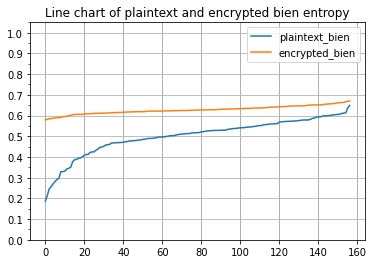

In [50]:
# Plot 1

title = 'Line chart of plaintext and encrypted shannon entropy'
ax = df.plot(y=['plaintext_shannon','encrypted_shannon'],kind='line',title=title, grid=True)
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=1)
ymajortick = arange(0,1.1,0.1)
yminortick = arange(0,1.1,0.05)
ax.set_yticks( ymajortick, minor=False )
ax.set_yticks( yminortick, minor=True )
ax.grid('on', which='both', axis='x' )
plt.savefig('Plots/rfc761/Comparison/tcpshannonlinecomparison.png', transparent=False)

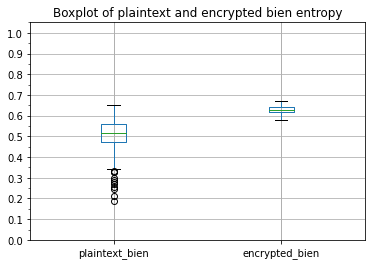

In [51]:
# Plot 2

title = 'Boxplot of plaintext and encrypted shannon entropy'
ax = df.plot(y=['plaintext_shannon','encrypted_shannon'],kind='box',title=title, grid=True)
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=1)
ymajortick = arange(0,1.1,0.1)
yminortick = arange(0,1.1,0.05)
ax.set_yticks( ymajortick, minor=False )
ax.set_yticks( yminortick, minor=True )
ax.grid('on', which='both', axis='x' )
plt.savefig('Plots/rfc761/Comparison/tcpshannonboxcomparison.png', transparent=False)

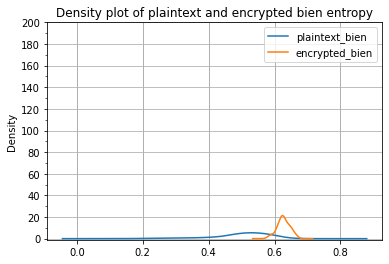

In [52]:
# Plot 3

title = 'Density plot of plaintext and encrypted shannon entropy'
ax = df.plot(y=['plaintext_shannon','encrypted_shannon'],kind='density',title=title, grid=True)
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=1)
ymajortick = arange(0,210,20)
yminortick = arange(0,210,10)
ax.set_yticks( ymajortick, minor=False )
ax.set_yticks( yminortick, minor=True )
ax.grid('on', which='both', axis='x' )
plt.savefig('Plots/rfc761/Comparison/tcpshannondensitycomparison.png', transparent=False)